In [1]:
import torch
import torchvision

import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.optim import Adam

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class MnistVAE(nn.Module):
    def __init__(self):
        super(MnistVAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, 5),
            nn.ReLU(),
            nn.Conv2d(4, 8, 5),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3200, 400),
            nn.ReLU(),
        )

        # self.mean_layer = nn.Linear(200, 10)
        # self.var_layer = nn.Linear(200, 10)

        self.mean_layer = nn.Linear(400, 2)
        self.var_layer = nn.Linear(400, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 400),
            nn.ReLU(),
            nn.Linear(400, 4000),
            nn.ReLU(),
            nn.Unflatten(1, (10, 20, 20)),
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        
        mean, var = self.mean_layer(x), self.var_layer(x)

        return mean, var

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, var = self.encode(x)
        x = self.reparameterization(mean, var)
        x = self.decode(x)

        return x, mean, var

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

batch_size = 64
train_set = torchvision.datasets.MNIST(root='./data/', train=True, download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.MNIST(root='./data/', train=False, download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [5]:
# def loss_function(outputs, inputs, mean, log_var):
def loss_function(outputs, inputs, mean, var):
    mse_loss = nn.functional.mse_loss(outputs, inputs, reduction='sum')
    kld = 0.5 * torch.sum(mean.pow(2) + var.pow(2) - torch.log(var.pow(2)) - 1)
    return mse_loss + kld

In [6]:
# model
model = MnistVAE().to(device)

# Optimizer
optimizer = Adam(model.parameters())
model.train()
for epoch in range(50):
    for i, data in enumerate(train_loader):
        inputs = data[0].to(device)
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
    
        # output of model
        outputs, mean, var = model(inputs)
        
        # loss function
        loss = loss_function(outputs, inputs, mean, var)
        loss.backward()
    
        optimizer.step()
        
        if i % 200 == 0:
            print(epoch, i)
            print(loss.item())
            print('---------')

torch.save([model], "Mnist Vae.pth")

0 0
64869.06640625
---------
0 200
35914.46484375
---------
0 400
34075.3984375
---------
0 600
35097.75
---------
0 800
33239.8046875
---------
1 0
33081.43359375
---------
1 200
33400.0546875
---------
1 400
35950.171875
---------
1 600
33831.03515625
---------
1 800
33776.5234375
---------
2 0
34778.921875
---------
2 200
32582.0625
---------
2 400
33597.66015625
---------
2 600
34371.86328125
---------
2 800
34131.71484375
---------
3 0
33857.75
---------
3 200
33184.05859375
---------
3 400
32810.234375
---------
3 600
33617.359375
---------
3 800
32391.2578125
---------
4 0
34396.3125
---------
4 200
35592.75
---------
4 400
33692.55078125
---------
4 600
31578.0703125
---------
4 800
34708.08984375
---------
5 0
32610.75390625
---------
5 200
31304.369140625
---------
5 400
33121.640625
---------
5 600
32744.203125
---------
5 800
34007.58203125
---------
6 0
33882.421875
---------
6 200
33595.71484375
---------
6 400
33953.5078125
---------
6 600
30677.71875
---------
6 800
325

In [7]:
def plot(img):
    np_img = img.cpu().numpy()
    plt.axis("off")
    plt.imshow(np_img.squeeze(), cmap="gray")
    plt.show()

In [65]:
index = 1
z = test_set[index][0].to(device)
img = torch.reshape(z, (1, 1, 28, 28))
a = model.encode(img)
a

(tensor([[ 0.5875, -0.2845]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[ 0.0274, -0.0166]], device='cuda:0', grad_fn=<AddmmBackward0>))

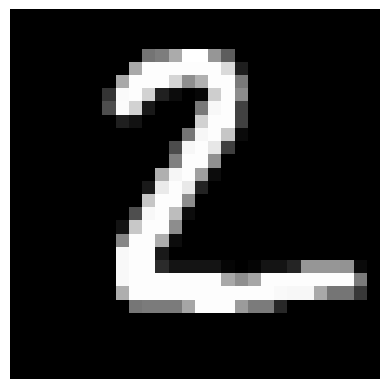

tensor([[ 0.6236, -0.2962]], device='cuda:0')


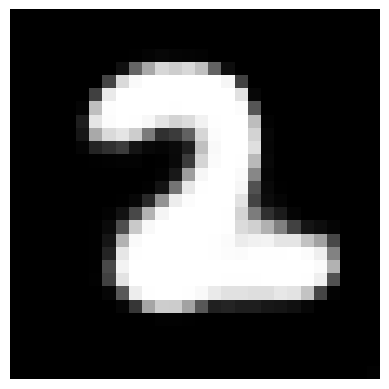

tensor([[ 0.5213, -0.3023]], device='cuda:0')


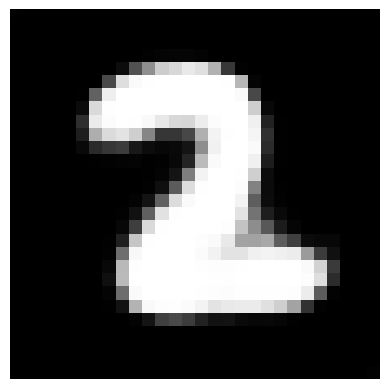

tensor([[ 0.5679, -0.2919]], device='cuda:0')


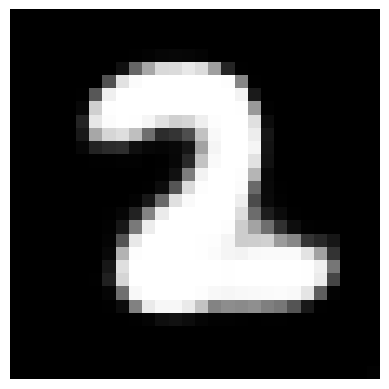

tensor([[ 0.6002, -0.2986]], device='cuda:0')


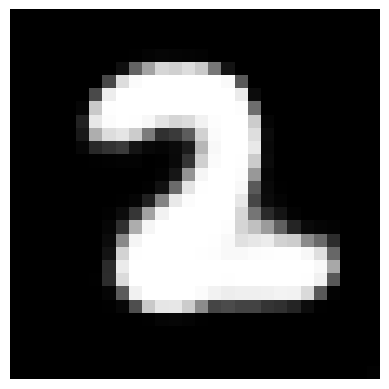

tensor([[ 0.6217, -0.2637]], device='cuda:0')


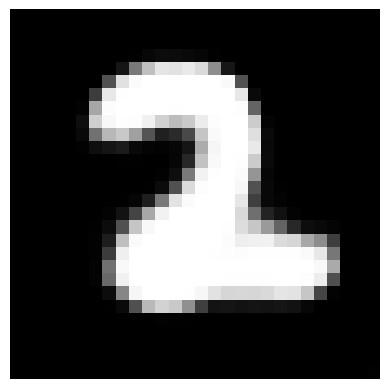

tensor([[ 0.5918, -0.2739]], device='cuda:0')


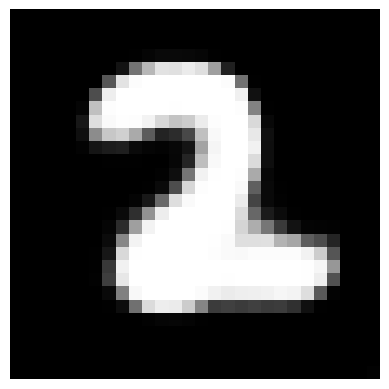

tensor([[ 0.5893, -0.2965]], device='cuda:0')


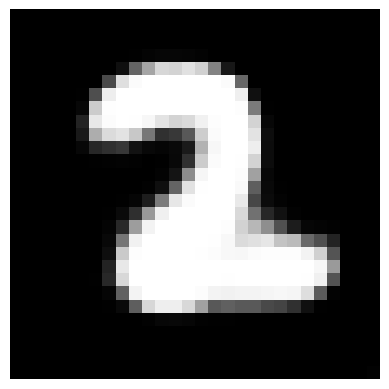

tensor([[ 0.6281, -0.2929]], device='cuda:0')


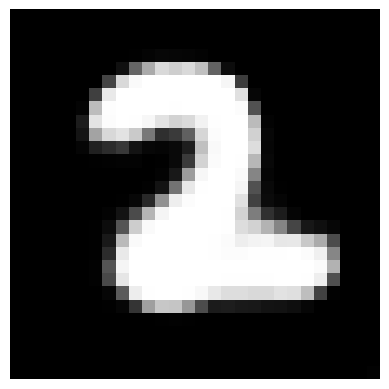

tensor([[ 0.5978, -0.2857]], device='cuda:0')


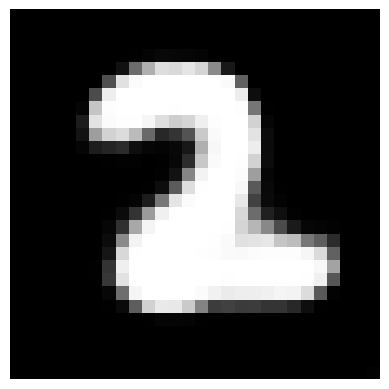

tensor([[ 0.5777, -0.2551]], device='cuda:0')


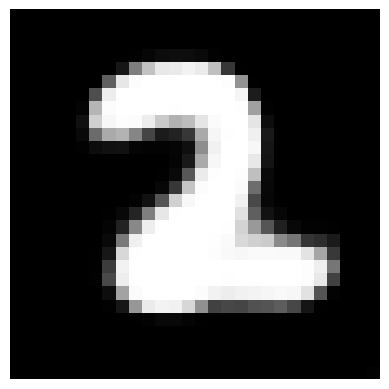

In [66]:
plot(img)

with torch.no_grad():
    model.eval()
    for jj in range(10):
        reparameterization = model.reparameterization(a[0], a[1])
        print(reparameterization)
        decode = model.decode(reparameterization)
        plot(decode)

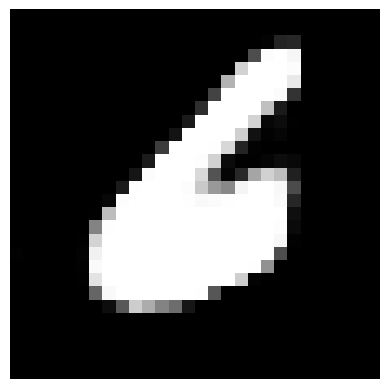

In [72]:
with torch.no_grad():
    model.eval()

    z = torch.tensor([[1.8236, 2.52962]])
    plot(model.decode(z.to(device)))